# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from reproject import reproject_interp
from scipy.interpolate import interp1d
import copy

from minot.ClusterTools import map_tools
import pitszi

import macsj0717_libs as libs

sigma2fwhm = 2 * np.sqrt(2*np.log(2))

# Parameters

In [2]:
outdir = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/'

# Cluster parameters
cl_redshift = 0.546
cl_M500     = 20*1e14*u.Msun
cl_coord    = SkyCoord(109.3806*u.deg, 37.7583*u.deg, frame='icrs')

# Sampling
reso = 4*u.arcsec
FoV = 4*u.arcmin
los_reso = 100*u.kpc
los_size = 2*u.Mpc

# Analysis parameters
ps_mask_lim = 0.1*100 # mJy
mask_theta = 2*u.arcmin
Nsim = 10
apply_radial_model = True

# Get the data

In [3]:
#===== Instrument parameters
beam_FWHM    = 18.2*u.arcsec
FoV_diameter = 2*u.arcmin
TF = libs.get_TF()

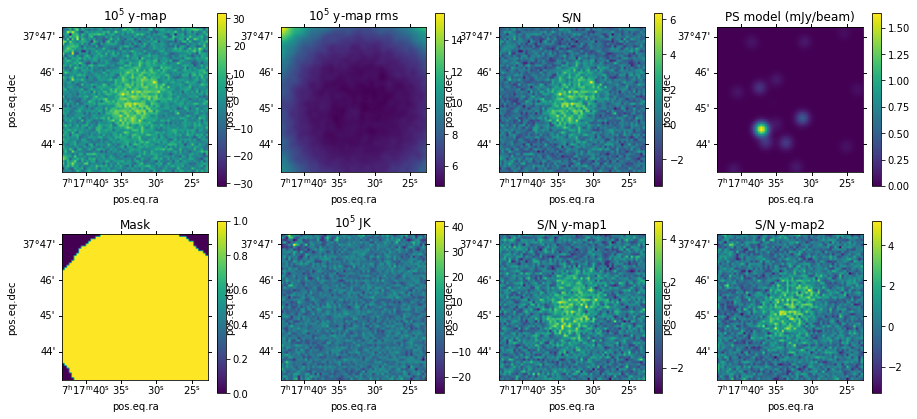

In [4]:
#===== Get the data
cl_head, y2jy, cl_img, cl_img1, cl_img2, cl_jk, cl_ps, cl_rms, cl_noise, cl_mask = libs.extract_data(FoV, reso, 
                                                                                                     ps_mask_lim,
                                                                                                     show=True)

In [5]:
#===== CIB MC
cib_mc = libs.simu_cib(cl_head['CRVAL1'], cl_head['CRVAL2'], cl_head, beam_FWHM, TF,
                       Nsim=Nsim, Scut_high=0.4, Scut_low=0.01)

0 / 10
5 / 10


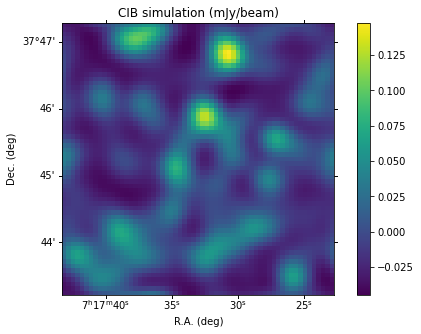

In [6]:
fig = plt.figure(0, figsize=(8, 5))
ax = plt.subplot(1, 1, 1, projection=WCS(cl_head))
plt.imshow(cib_mc[3], origin='lower')
plt.colorbar()
plt.title('CIB simulation (mJy/beam)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
plt.savefig(outdir+'/CIB_simulation.pdf')

In [7]:
cib_mc = cib_mc/np.mean(y2jy)

# Define the model, data and inference

In [8]:
#========== cluster data
cl_data  = libs.def_data(cl_img,  cl_head, cl_noise, cl_mask, beam_FWHM, TF, outdir, Nsim)
cl_data1 = libs.def_data(cl_img1, cl_head, cl_noise*2**0.5, cl_mask, beam_FWHM, TF, outdir, Nsim)
cl_data2 = libs.def_data(cl_img2, cl_head, cl_noise*2**0.5, cl_mask, beam_FWHM, TF, outdir, Nsim)

In [9]:
#========== cluster model
cl_model = pitszi.Model(name='Model', RA=cl_coord.ra, Dec=cl_coord.dec, 
                        redshift=cl_redshift, M500=cl_M500, 
                        silent=True, output_dir=outdir)
cl_model.set_pressure_profile_universal_param('A10MD')
cl_model.map_header = cl_head
cl_model.los_reso  = los_reso
cl_model.los_size  = los_size
cl_model.R_truncation = 10*u.Mpc

In [10]:
#========== Inference radial
cl_Rinfer = pitszi.InferenceRadial(cl_data, cl_model, 
                                   method_use_covmat=False,
                                   silent=False, output_dir=outdir)

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                    Radial Inference                        
------------------------------------------------------------


# Fit the smooth model to the data

In [11]:
#========== Curvefit the profile
RA  = cl_Rinfer.model.coord.ra
Dec = cl_Rinfer.model.coord.dec

fitpar_prof = {
#'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
#'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
#'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
#'b': {'guess':[5, 0.5], 'unit': None, 'limit':[0, 10]},
#'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[-1, 3]},
'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
#'RA': {'guess':[RA.to_value('arcmin'), 0.5], 'unit': u.arcmin, 'limit':[RA.to_value('arcmin')-0.5, RA.to_value('arcmin')+0.5]},
#'Dec': {'guess':[Dec.to_value('arcmin'), 0.5], 'unit': u.arcmin, 'limit':[Dec.to_value('arcmin')-0.5, Dec.to_value('arcmin')+0.5]},
#'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
#'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
'ZL':{'guess':[0,1e-5],'unit':None},
}

plist, popt, pcov = cl_Rinfer.run_curvefit_profile(fitpar_prof, 
                                                   show_fit_result=True, 
                                                   set_bestfit=True)

param 0 (M500): 
   median   = 19.89582296790195 -0.5055588462965694 +0.505350763839008
   best-fit = 19.895319581762788 -0.5050554601574078 +0.5058541499781697
   M500 = 19.89582296790195_{-0.5055588462965694}^{0.505350763839008}
param 1 (ZL): 
   median   = 1.8518415917949835e-05 -9.12924185333992e-07 +9.245018228761508e-07
   best-fit = 1.818456505124587e-05 -5.790733186300257e-07 +1.258352689580117e-06
   ZL = 1.8518415917949835e-05_{-9.12924185333992e-07}^{9.245018228761508e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


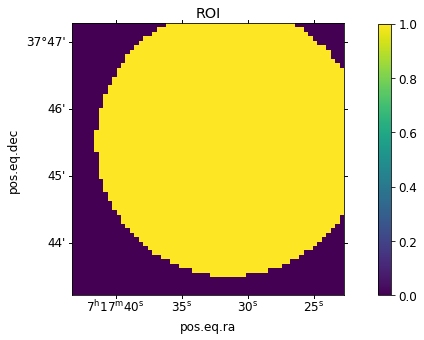

In [12]:
#===== Define the ROI
roi = libs.def_roi(cl_head, cl_Rinfer.model, mask_theta=mask_theta, show=True)

In [13]:
#===== Defines pressure fluctuation models

cl_model1 = copy.deepcopy(cl_Rinfer.model)
cl_model2 = copy.deepcopy(cl_Rinfer.model)
cl_model3 = copy.deepcopy(cl_Rinfer.model)

cl_model1.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                        'statistics':'gaussian',
                                        'Norm': 0.5, 
                                        'slope': -11/3.0,
                                        'Linj': 1000*u.kpc,
                                        'Ldis': 1*u.kpc}
cl_model2.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                        'statistics':'lognormal',
                                        'Norm': 0.5, 
                                        'slope': -11/3.0,
                                        'Linj': 1000*u.kpc,
                                        'Ldis': 1*u.kpc}
cl_model3.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                        'statistics':'gaussian',
                                        'Norm': 0.2, 
                                        'slope': -11/3.0,
                                        'Linj': 250*u.kpc,
                                        'Ldis': 1*u.kpc}

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


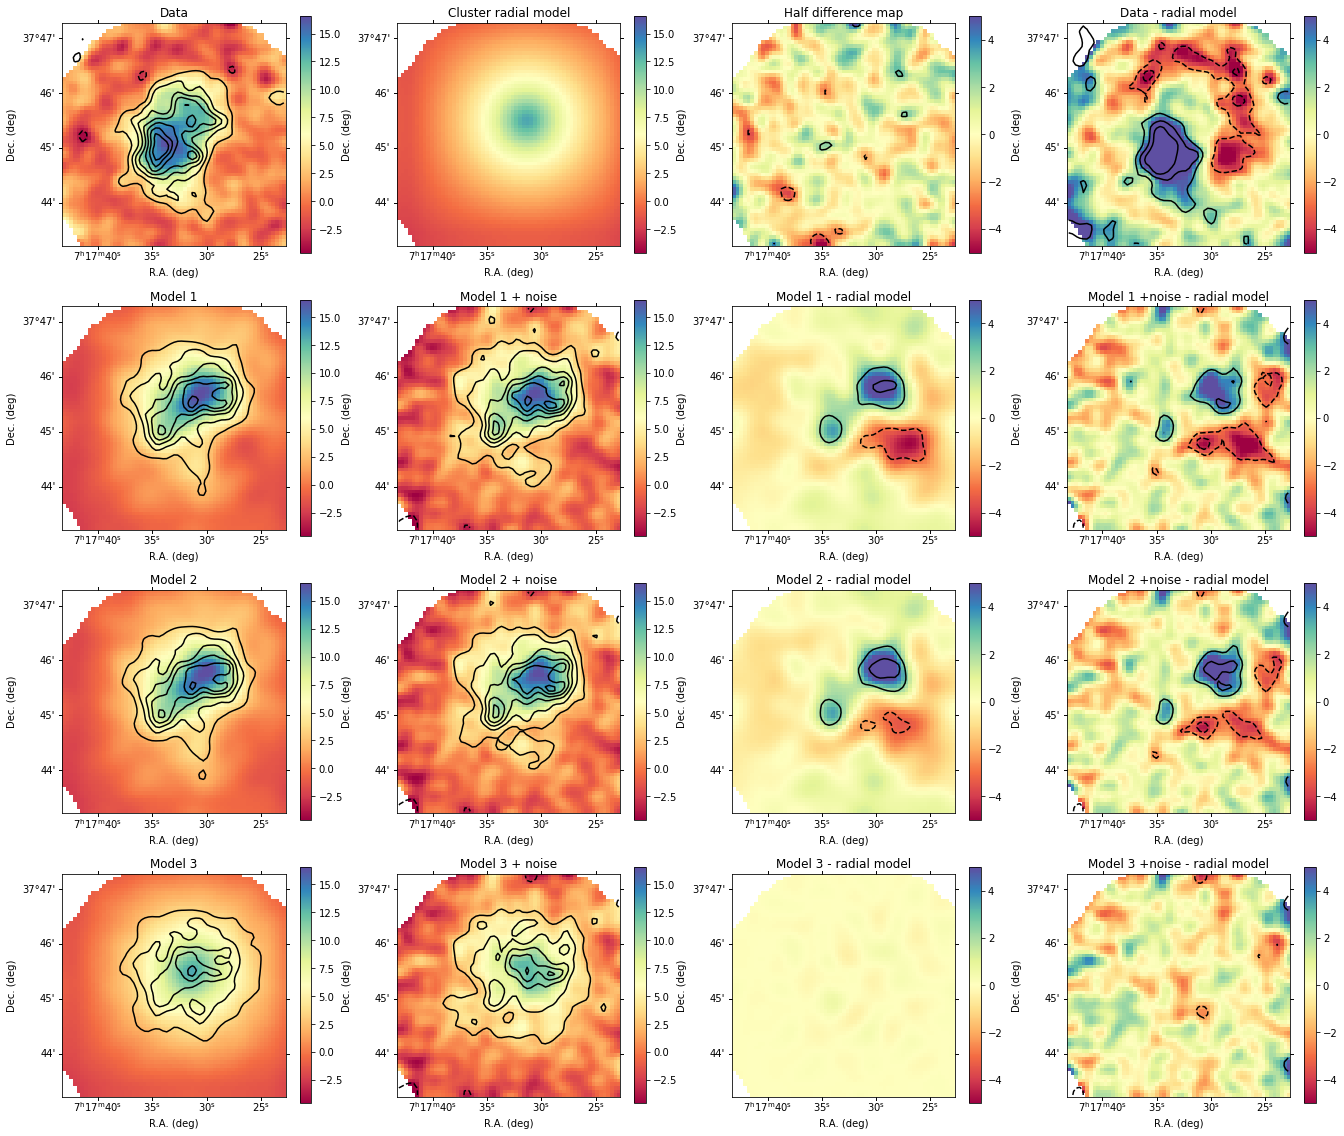

In [14]:
#===== Show the images

smooth_FWHM = 15*u.arcsec

# Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(23, 20))
model_sph = cl_Rinfer.get_radial_model()
    
rms = cl_data.get_noise_rms_from_model(Nmc=Nsim, smooth_fwhm=smooth_FWHM)
rms = gaussian_filter(rms, sigma=10/3600/sigma2fwhm/cl_head['CDELT2'])
    
rng = [np.nanmin(cl_data.mask*gaussian_filter(cl_img, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5),
       np.nanmax(cl_data.mask*gaussian_filter(cl_img, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5)]

msk = copy.deepcopy(cl_data.mask)
msk[cl_data.mask == 0] = np.nan

inoise    = 1
seedfluct = 6
    
########## Data
#----- Image
ax = plt.subplot(4, 4, 1, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title('Data')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
    
#----- Cluster model
ax = plt.subplot(4, 4, 2, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.title('Cluster radial model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Residual model
ax = plt.subplot(4, 4, 3, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_jk, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=-5, vmax=5)
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_jk, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-9,-6,-3,3,6,9], colors='k')
plt.title('Half difference map')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Residual model
ax = plt.subplot(4, 4, 4, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img-model_sph - np.mean((cl_img-model_sph)[roi==1]), sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=-5, vmax=5)
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img-model_sph - np.mean((cl_img-model_sph)[roi==1]), 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-9,-6,-3,3,6,9], colors='k')
plt.title('Data - radial model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')


########## Model 1
sz_image1 = cl_model1.get_sz_map(seed=seedfluct, irfs_convolution_beam=beam_FWHM, irfs_convolution_TF=TF)
sz_image1n = sz_image1 + cl_data.noise_mc[inoise]
sz_image1 -= np.mean(sz_image1-model_sph)
sz_image1n -= np.mean(sz_image1n-model_sph)

#----- Realization model
ax = plt.subplot(4, 4, 5, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(sz_image1, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(sz_image1, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title('Model 1')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Realization model
ax = plt.subplot(4, 4, 6, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(sz_image1n, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(sz_image1n, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title('Model 1 + noise')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Realization model residual
ax = plt.subplot(4, 4, 7, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(sz_image1-model_sph - np.mean((sz_image1-model_sph)[roi==1]), sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=-5, vmax=5)
cb = plt.colorbar()
plt.contour(gaussian_filter(sz_image1-model_sph - np.mean((sz_image1-model_sph)[roi==1]), 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-9,-6,-3,3,6,9], colors='k')
plt.title('Model 1 - radial model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Realization model residual
ax = plt.subplot(4, 4, 8, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(sz_image1n-model_sph - np.mean((sz_image1n-model_sph)[roi==1]),
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=-5, vmax=5)
cb = plt.colorbar()
plt.contour(gaussian_filter(sz_image1n-model_sph - np.mean((sz_image1n-model_sph)[roi==1]), 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-9,-6,-3,3,6,9], colors='k')
plt.title('Model 1 +noise - radial model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

########## Model 2
sz_image2 = cl_model2.get_sz_map(seed=seedfluct, irfs_convolution_beam=beam_FWHM, irfs_convolution_TF=TF)
sz_image2n = sz_image2 + cl_data.noise_mc[inoise]
sz_image2 -= np.mean(sz_image2-model_sph)
sz_image2n -= np.mean(sz_image2n-model_sph)

#----- Realization model
ax = plt.subplot(4, 4, 9, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(sz_image2, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(sz_image2, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title('Model 2')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Realization model
ax = plt.subplot(4, 4, 10, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(sz_image2n, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(sz_image2n, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title('Model 2 + noise')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Realization model residual
ax = plt.subplot(4, 4, 11, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(sz_image2-model_sph - np.mean((sz_image2-model_sph)[roi==1]),
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=-5, vmax=5)
cb = plt.colorbar()
plt.contour(gaussian_filter(sz_image2-model_sph - np.mean((sz_image2-model_sph)[roi==1]), 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-9,-6,-3,3,6,9], colors='k')
plt.title('Model 2 - radial model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Realization model residual
ax = plt.subplot(4, 4, 12, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(sz_image2n-model_sph - np.mean((sz_image2n-model_sph)[roi==1]), sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=-5, vmax=5)
cb = plt.colorbar()
plt.contour(gaussian_filter(sz_image2n-model_sph - np.mean((sz_image2n-model_sph)[roi==1]), 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-9,-6,-3,3,6,9], colors='k')
plt.title('Model 2 +noise - radial model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

########## Model 3
sz_image3 = cl_model3.get_sz_map(seed=seedfluct, irfs_convolution_beam=beam_FWHM, irfs_convolution_TF=TF)
sz_image3n = sz_image3 + cl_data.noise_mc[inoise]
sz_image3 -= np.mean(sz_image3-model_sph)
sz_image3n -= np.mean(sz_image3n-model_sph)

#----- Realization model
ax = plt.subplot(4, 4, 13, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(sz_image3, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(sz_image3, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title('Model 3')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Realization model
ax = plt.subplot(4, 4, 14, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(sz_image3n, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(sz_image3n, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title('Model 3 + noise')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Realization model residual
ax = plt.subplot(4, 4, 15, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(sz_image3-model_sph - np.mean((sz_image3-model_sph)[roi==1]), sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=-5, vmax=5)
cb = plt.colorbar()
plt.contour(gaussian_filter(sz_image3-model_sph - np.mean((sz_image3-model_sph)[roi==1]), 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-9,-6,-3,3,6,9], colors='k')
plt.title('Model 3 - radial model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Realization model residual
ax = plt.subplot(4, 4, 16, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(sz_image3n-model_sph - np.mean((sz_image3n-model_sph)[roi==1]), sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=-5, vmax=5)
cb = plt.colorbar()
plt.contour(gaussian_filter(sz_image3n-model_sph - np.mean((sz_image3n-model_sph)[roi==1]), 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-9,-6,-3,3,6,9], colors='k')
plt.title('Model 3 +noise - radial model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
plt.savefig(outdir+'/residual_map_comparison.pdf')

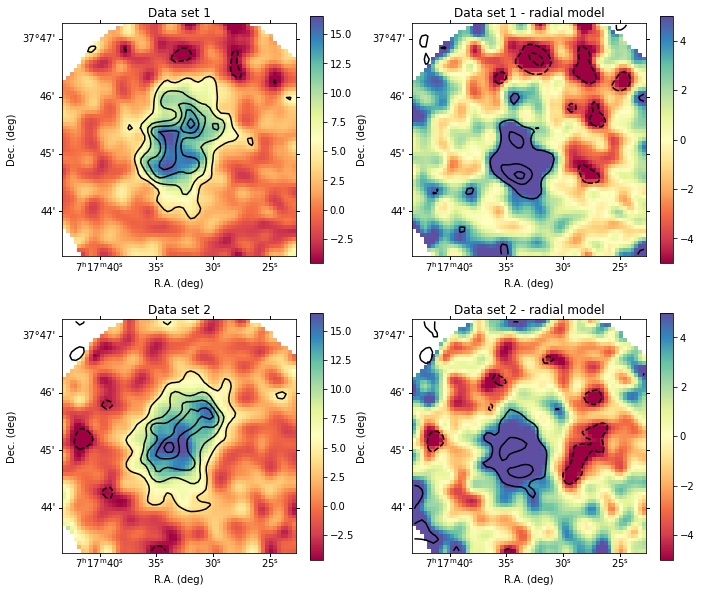

In [15]:
#===== Show the set 1 and set 2 images

smooth_FWHM = 15*u.arcsec

# Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(11.5, 10))
    
rms1 = cl_data1.get_noise_rms_from_model(Nmc=Nsim, smooth_fwhm=smooth_FWHM)
rms1 = gaussian_filter(rms1, sigma=10/3600/sigma2fwhm/cl_head['CDELT2'])
rms2 = cl_data2.get_noise_rms_from_model(Nmc=Nsim, smooth_fwhm=smooth_FWHM)
rms2 = gaussian_filter(rms2, sigma=10/3600/sigma2fwhm/cl_head['CDELT2'])

########## Data
#----- Image
ax = plt.subplot(2, 2, 1, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img1, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img1, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms1, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title('Data set 1')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
    
#----- Residual model
ax = plt.subplot(2, 2, 2, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img1-model_sph - np.mean((cl_img1-model_sph)[roi==1]), sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=-5, vmax=5)
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img1-model_sph - np.mean((cl_img1-model_sph)[roi==1]), 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms2, 
            levels=[-9,-6,-3,3,6,9], colors='k')
plt.title('Data set 1 - radial model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Cluster model
ax = plt.subplot(2, 2, 3, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img2, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img2, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms1, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title('Data set 2')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')


#----- Residual model
ax = plt.subplot(2, 2, 4, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img2-model_sph - np.mean((cl_img2-model_sph)[roi==1]), sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=-5, vmax=5)
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img2-model_sph - np.mean((cl_img2-model_sph)[roi==1]), 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms2, 
            levels=[-9,-6,-3,3,6,9], colors='k')
plt.title('Data set 2 - radial model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

plt.savefig(outdir+'/residual_map_comparison_sets.pdf')

# Statistics of the fluctuations

In [16]:
nbinhist = 20

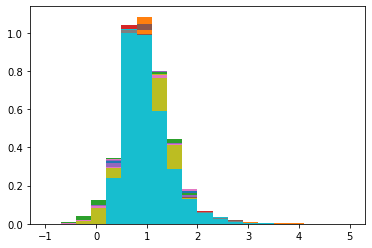

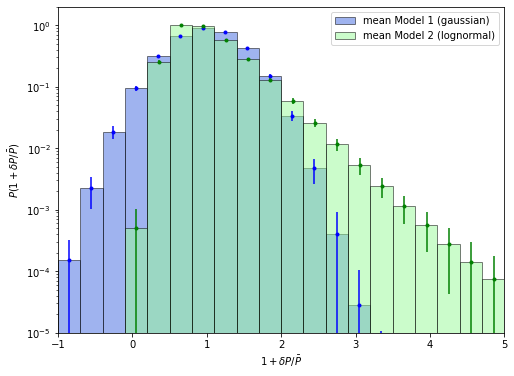

In [17]:
#========== Statistics for delta P / P
vec1 = []
vec2 = []
n1 = []
n2 = []
for i in range(100):
    dPi1 = cl_model1.get_pressure_cube_fluctuation()+1
    dPi2 = cl_model2.get_pressure_cube_fluctuation()+1
    vec1.append(dPi1)
    vec2.append(dPi2)
    N1, bv, _  = plt.hist(dPi1.flatten(), range=(-1,5.0), density=True, bins=nbinhist)
    N2, _, _   = plt.hist(dPi2.flatten(), range=(-1,5.0), density=True, bins=nbinhist)
    n1.append(N1)
    n2.append(N2)
bv =  0.5 * (bv[1:] + bv[:-1])

fig = plt.figure(0, figsize=(8, 6))
plt.hist(np.array(vec1).flatten(), range=(-1,5.0), density=True, 
         bins=nbinhist, edgecolor='black', facecolor='royalblue', alpha=0.5, label='mean Model 1 (gaussian)')
plt.errorbar(bv-0.005, np.mean(np.array(n1), axis=0), np.std(np.array(n1), axis=0), ls='', marker='.', color='blue')
plt.hist(np.array(vec2).flatten(), range=(-1,5.0), density=True,
         bins=nbinhist, edgecolor='black', facecolor='palegreen',  alpha=0.5, label='mean Model 2 (lognormal)')
plt.errorbar(bv+0.005, np.mean(np.array(n2), axis=0), np.std(np.array(n2), axis=0), ls='', marker='.', color='green')
plt.xlim(-1,5)
plt.ylim(1e-5,2)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$1+\delta P / \bar{P}$')
plt.ylabel(r'$P\left(1+\delta P / \bar{P}\right)$')
plt.savefig(outdir+'/statistics_dP.pdf')

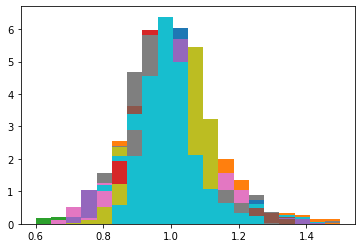

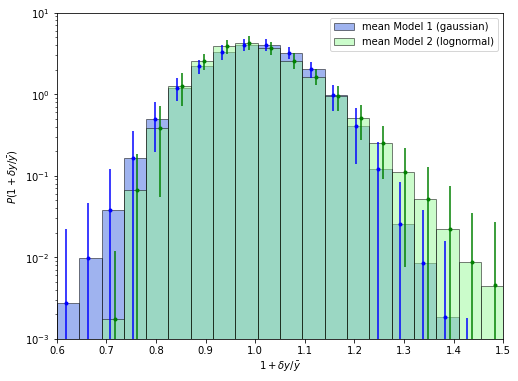

In [18]:
#========== Statistics for delta y / y
vec1 = []
vec2 = []
n1 = []
n2 = []
ysphA = cl_model1.get_sz_map(no_fluctuations=True, irfs_convolution_beam=beam_FWHM, irfs_convolution_TF=TF)
ysphB = cl_model1.get_sz_map(no_fluctuations=True, irfs_convolution_beam=beam_FWHM)
for i in range(100):
    y1 = cl_model1.get_sz_map(irfs_convolution_beam=beam_FWHM, irfs_convolution_TF=TF)
    y2 = cl_model2.get_sz_map(irfs_convolution_beam=beam_FWHM, irfs_convolution_TF=TF)

    dsz_image1 = (y1-ysphA)/ysphB
    dsz_image2 = (y2-ysphA)/ysphB
    
    vec1.append(1+dsz_image1[roi==1].flatten())
    vec2.append(1+dsz_image2[roi==1].flatten())

    N1, bv, _  = plt.hist(1+dsz_image1[roi==1].flatten(), range=(0.6,1.5), density=True, bins=nbinhist)
    N2, _, _  = plt.hist(1+dsz_image2[roi==1].flatten(), range=(0.6,1.5), density=True, bins=nbinhist)
    n1.append(N1)
    n2.append(N2)
    
bv =  0.5 * (bv[1:] + bv[:-1])

fig = plt.figure(0, figsize=(8, 6))

plt.hist(np.array(vec1).flatten(), range=(0.6,1.5), density=True, 
         bins=nbinhist, edgecolor='black', facecolor='royalblue', alpha=0.5, label='mean Model 1 (gaussian)')
plt.errorbar(bv-0.005, np.mean(np.array(n1), axis=0), np.std(np.array(n1), axis=0), ls='', marker='.', color='blue')
plt.hist(np.array(vec2).flatten(), range=(0.6,1.5), density=True,
         bins=nbinhist, edgecolor='black', facecolor='palegreen',  alpha=0.5, label='mean Model 2 (lognormal)')
plt.errorbar(bv+0.005, np.mean(np.array(n2), axis=0), np.std(np.array(n2), axis=0), ls='', marker='.', color='green')

plt.xlim(0.6,1.5)
plt.ylim(1e-3,10)

plt.yscale('log')
plt.legend()
plt.xlabel(r'$1+\delta y / \bar{y}$')
plt.ylabel(r'$P\left(1+\delta y / \bar{y}\right)$')
plt.savefig(outdir+'/statistics_dy.pdf')

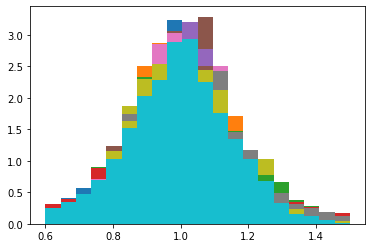

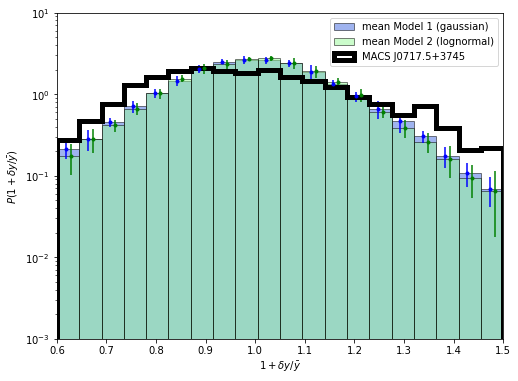

In [22]:
beamsm = 10*u.arcsec

#========== Statistics for delta y / y
vec1 = []
vec2 = []
n1 = []
n2 = []

ysphA = cl_model1.get_sz_map(no_fluctuations=True, irfs_convolution_beam=(beam_FWHM**2+beamsm**2)**0.5, irfs_convolution_TF=TF)
ysphB = cl_model1.get_sz_map(no_fluctuations=True, irfs_convolution_beam=(beam_FWHM**2+beamsm**2)**0.5)

for i in range(np.amin([100, cl_data.noise_mc.shape[0]])):
    y1 = cl_model1.get_sz_map(irfs_convolution_beam=(beam_FWHM**2+beamsm**2)**0.5, irfs_convolution_TF=TF)
    y2 = cl_model2.get_sz_map(irfs_convolution_beam=(beam_FWHM**2+beamsm**2)**0.5, irfs_convolution_TF=TF)
    y1 = y1 + gaussian_filter(cl_data.noise_mc[i], sigma=beamsm.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])
    y2 = y2 + gaussian_filter(cl_data.noise_mc[i], sigma=beamsm.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])
    
    dsz_image1 = (y1-ysphA)/ysphB
    dsz_image2 = (y2-ysphA)/ysphB
    vec1.append(1+dsz_image1[roi==1].flatten())
    vec2.append(1+dsz_image2[roi==1].flatten())

    N1, bv, _  = plt.hist(1+dsz_image1[roi==1].flatten(), range=(0.6,1.5), density=True, bins=nbinhist)
    N2, _, _  = plt.hist(1+dsz_image2[roi==1].flatten(), range=(0.6,1.5), density=True, bins=nbinhist)
    n1.append(N1)
    n2.append(N2)
bv =  0.5 * (bv[1:] + bv[:-1])

fig = plt.figure(0, figsize=(8, 6))

plt.hist(np.array(vec1).flatten(), range=(0.6,1.5), density=True, 
         bins=nbinhist, edgecolor='black', facecolor='royalblue', alpha=0.5, label='mean Model 1 (gaussian)')
plt.errorbar(bv-0.005, np.mean(np.array(n1), axis=0), np.std(np.array(n1), axis=0), ls='', marker='.', color='blue')
plt.hist(np.array(vec2).flatten(), range=(0.6,1.5), density=True,
         bins=nbinhist, edgecolor='black', facecolor='palegreen',  alpha=0.5, label='mean Model 2 (lognormal)')
plt.errorbar(bv+0.005, np.mean(np.array(n2), axis=0), np.std(np.array(n2), axis=0), ls='', marker='.', color='green')

ysphA = cl_Rinfer.model.get_sz_map(no_fluctuations=True, irfs_convolution_beam=(beam_FWHM**2+beamsm**2)**0.5, irfs_convolution_TF=TF)
ysphB = cl_Rinfer.model.get_sz_map(no_fluctuations=True, irfs_convolution_beam=(beam_FWHM**2+beamsm**2)**0.5)
img = (gaussian_filter(cl_img, sigma=beamsm.to_value('deg')/sigma2fwhm/cl_head['CDELT2']) - ysphA)
img = img-np.mean(img[roi==1])
img = img/ysphB
plt.hist(img[roi==1].flatten()+1, range=(0.6,1.5), density=True,
         bins=nbinhist, histtype='step', color='k', lw=5, label='MACS J0717.5+3745')

plt.xlim(0.6,1.5)
plt.ylim(1e-3,10)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$1+\delta y / \bar{y}$')
plt.ylabel(r'$P\left(1+\delta y / \bar{y}\right)$')
plt.savefig(outdir+'/statistics_dyNoise.pdf')

# Inference Pk 

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                 Fluctuation Inference                      
------------------------------------------------------------
----- Checking the inputs -----
      - Data1, data2, and model projection OK.
                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------

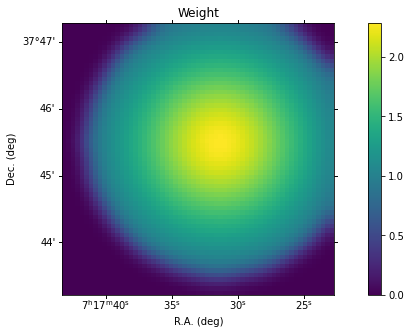

In [23]:
# Pk binning
Nbins_pk = 30
scale_bins = 'lin'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(beam_FWHM.to('arcsec'))

# Define the inference
cl_Finfer1 = pitszi.InferenceFluctuation(cl_data, cl_model1, 
                                         method_use_covmat=True,
                                         nuisance_bkg_mc1=cib_mc,
                                         kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                         output_dir=outdir, silent=False)
cl_Finfer2 = pitszi.InferenceFluctuation(cl_data, cl_model2, 
                                         method_use_covmat=True,
                                         nuisance_bkg_mc1=cib_mc,
                                         kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                         output_dir=outdir, silent=False)
cl_Finfer3 = pitszi.InferenceFluctuation(cl_data, cl_model3, 
                                         method_use_covmat=True,
                                         nuisance_bkg_mc1=cib_mc,
                                         kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                         output_dir=outdir, silent=False)

cl_FinferX = pitszi.InferenceFluctuation(cl_data1, cl_model1, data2=cl_data2, 
                                         method_use_covmat=True,
                                         nuisance_bkg_mc1=cib_mc,
                                         nuisance_bkg_mc2=cib_mc,
                                         kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                         output_dir=outdir, silent=False)

# Compute and show the weight
cl_Finfer1.set_method_w8(roi_mask=roi,apply_radial_model=apply_radial_model, 
                         conv_radial_model_beam=True, conv_radial_model_TF=False, 
                         remove_GNFW_core=True, smooth_FWHM=20*u.arcsec)
cl_Finfer2.set_method_w8(roi_mask=roi,apply_radial_model=apply_radial_model, 
                         conv_radial_model_beam=True, conv_radial_model_TF=False, 
                         remove_GNFW_core=True, smooth_FWHM=20*u.arcsec)
cl_Finfer3.set_method_w8(roi_mask=roi,apply_radial_model=apply_radial_model, 
                         conv_radial_model_beam=True, conv_radial_model_TF=False, 
                         remove_GNFW_core=True, smooth_FWHM=20*u.arcsec)

cl_FinferX.set_method_w8(roi_mask=roi,apply_radial_model=apply_radial_model, 
                         conv_radial_model_beam=True, conv_radial_model_TF=False, 
                         remove_GNFW_core=True, smooth_FWHM=20*u.arcsec)

# Show the weight
fig = plt.figure(0, figsize=(12, 5))
ax = plt.subplot(1, 1, 1, projection=WCS(cl_head))
plt.imshow(cl_Finfer1.method_w8, origin='lower')
plt.colorbar()
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
plt.title('Weight')
plt.savefig(outdir+'/W8map.pdf')

In [24]:
cl_Finfer1.pk_setup()
cl_Finfer2.pk_setup()
cl_Finfer3.pk_setup()
cl_FinferX.pk_setup()

----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [ 4.  4.  4.  8.  4. 12.  8. 12. 12. 12. 16. 12. 12. 16. 24. 16. 16. 28.
 20. 20. 32. 24. 32. 24. 28. 36. 28. 32. 20. 44.]
      - Minimal count in k bins: 4.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing
----- The setup is done -----
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [ 4.  4.  4.  8.  4. 12.  8. 12. 12. 12. 16. 12. 12. 16. 24. 16. 16. 28.
 20. 20. 32. 24. 32. 24. 28. 36. 28. 32. 20. 44.]
      - Minimal count in k bins: 4.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing
----- The setup is done -----
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [ 4.  4.  4.  8.  4. 12.  8. 12. 12. 12. 16. 12. 12. 16. 24. 16. 16. 28.
 20. 20. 32. 24. 32. 

In [25]:
unit = 'kpc'
if unit == 'arcsec':
    phys=False
if unit == 'kpc':
    phys=True
    
k2d, pk2d_data = cl_Finfer1.get_pk2d_data(physical=phys)
k2d, pk2d_noise, pk2d_noisecovmat = cl_Finfer1.get_pk2d_noise_statistics(physical=phys)
k2d, pk2d_modref, pk2d_modcovmat = cl_Finfer1.get_pk2d_model_statistics(physical=phys, Nmc=Nsim)
k2d, pk2d_bkg, pk2d_bkgcovmat = cl_Finfer1.get_pk2d_bkg_statistics(physical=phys)

cl_Finfer1.nuisance_Abkg = 0
cl_Finfer1.nuisance_Anoise = 0
k2d, pk2d_test_modbrute  = cl_Finfer1.get_pk2d_model_brute(physical=phys)
k2d, pk2d_test_moddeproj = cl_Finfer1.get_pk2d_model_proj(physical=phys)

In [26]:
cl_Finfer2.nuisance_Abkg = 0
cl_Finfer2.nuisance_Anoise = 0
cl_Finfer3.nuisance_Abkg = 0
cl_Finfer3.nuisance_Anoise = 0
_, pk2d_modref2, pk2d_modcovmat2 = cl_Finfer2.get_pk2d_model_statistics(physical=phys, Nmc=Nsim)
_, pk2d_test_modbrute2  = cl_Finfer2.get_pk2d_model_brute(physical=phys)
_, pk2d_test_moddeproj2 = cl_Finfer2.get_pk2d_model_proj(physical=phys)

_, pk2d_modref3, pk2d_modcovmat3 = cl_Finfer3.get_pk2d_model_statistics(physical=phys, Nmc=Nsim)
_, pk2d_test_modbrute3  = cl_Finfer3.get_pk2d_model_brute(physical=phys)
_, pk2d_test_moddeproj3 = cl_Finfer3.get_pk2d_model_proj(physical=phys)

In [27]:
_, pk2d_dataX = cl_FinferX.get_pk2d_data(physical=phys)
_, pk2d_noiseX, pk2d_noisecovmatX = cl_FinferX.get_pk2d_noise_statistics(physical=phys)
_, pk2d_modrefX, pk2d_modcovmatX = cl_FinferX.get_pk2d_model_statistics(physical=phys, Nmc=Nsim)
_, pk2d_bkgX, pk2d_bkgcovmatX = cl_FinferX.get_pk2d_bkg_statistics(physical=phys)
_, pk2d_test_modbruteX  = cl_Finfer2.get_pk2d_model_brute(physical=phys)
_, pk2d_test_moddeprojX = cl_Finfer2.get_pk2d_model_proj(physical=phys)

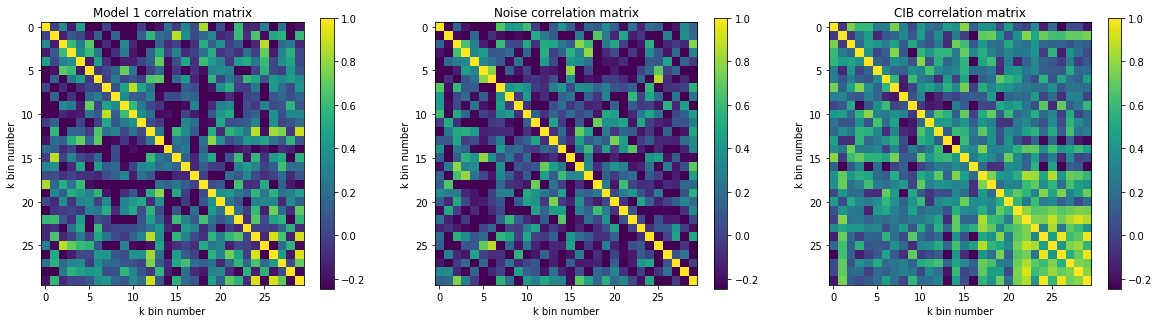

In [28]:
fig = plt.figure(0, figsize=(20, 5))
ax = plt.subplot(1, 3, 1)
plt.imshow(pitszi.utils.correlation_from_covariance(pk2d_modcovmat), vmin=-0.25, vmax=1)
plt.colorbar()
plt.title('Model 1 correlation matrix')
plt.xlabel('k bin number')
plt.ylabel('k bin number')

ax = plt.subplot(1, 3, 2)
plt.imshow(pitszi.utils.correlation_from_covariance(pk2d_noisecovmat), vmin=-0.25, vmax=1)
plt.colorbar()
plt.title('Noise correlation matrix')
plt.xlabel('k bin number')
plt.ylabel('k bin number')

ax = plt.subplot(1, 3, 3)
plt.imshow(pitszi.utils.correlation_from_covariance(pk2d_bkgcovmat), vmin=-0.25, vmax=1)
plt.colorbar()
plt.title('CIB correlation matrix')
plt.xlabel('k bin number')
plt.ylabel('k bin number')
plt.savefig(outdir+'/CovarianceMatrices.pdf')

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in sqrt


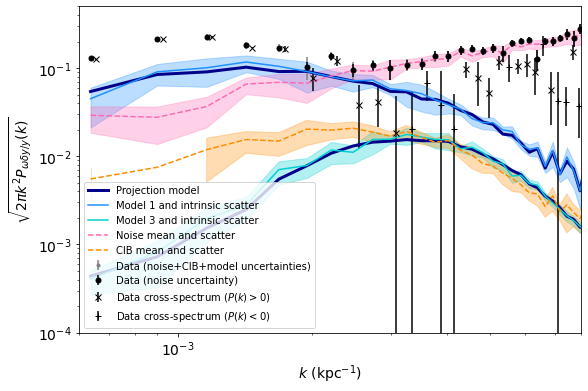

In [29]:
err_noise = (np.sqrt(2*np.pi*k2d**2)/(2*np.sqrt(pk2d_data))*np.diag(pk2d_noisecovmat)**0.5).value
err_noiseX = (np.sqrt(2*np.pi*k2d**2)/(2*np.sqrt(np.abs(pk2d_data)))*np.diag(pk2d_noisecovmatX)**0.5).value
err_tot   = (np.sqrt(2*np.pi*k2d**2)/(2*np.sqrt(pk2d_data))*(np.diag(pk2d_noisecovmat)
                                                            + np.diag(pk2d_bkgcovmat)
                                                            + np.diag(pk2d_modcovmat))**0.5).value
k = k2d.to_value(unit+'-1')
    
    
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(9, 6))

plt.errorbar(k, np.sqrt(2*np.pi*k**2*pk2d_data.value), err_tot, marker='.', ls='', color='grey',
             label='Data (noise+CIB+model uncertainties)')
plt.errorbar(k, np.sqrt(2*np.pi*k**2*pk2d_data.value), err_noise, marker='o', markersize=5, ls='', color='k',
             label='Data (noise uncertainty)')
plt.errorbar(k*1.03, np.sqrt(2*np.pi*k**2*(pk2d_dataX.value)), err_noiseX, marker='x', ls='', color='k',
             label='Data cross-spectrum ($P(k)>0$)')
plt.errorbar(k*1.03, np.sqrt(2*np.pi*k**2*(-pk2d_dataX.value)), err_noiseX, marker='+', ls='', color='k',
             label='Data cross-spectrum ($P(k)<0$)')

# Model brute force and projection
#plt.plot(k, np.sqrt(2*np.pi*k**2*pk2d_test_modbrute), color='r', lw=3, label='1 brute force model')
plt.plot(k, np.sqrt(2*np.pi*k**2*pk2d_test_moddeproj), color='darkblue', lw=3, label='Projection model')
plt.plot(k, np.sqrt(2*np.pi*k**2*pk2d_test_moddeproj3), color='darkblue', lw=3)

# Model reference
plt.plot(k, np.sqrt(2*np.pi*k**2*pk2d_modref), color='dodgerblue', label='Model 1 and intrinsic scatter')
plt.fill_between(k, np.sqrt(2*np.pi*k**2*(pk2d_modref.value-np.diag(pk2d_modcovmat.value)**0.5)),
                 np.sqrt(2*np.pi*k**2*(pk2d_modref.value+np.diag(pk2d_modcovmat.value)**0.5)),
                 color='dodgerblue', alpha=0.3)

#plt.plot(k, np.sqrt(2*np.pi*k**2*pk2d_modref2), color='cyan', label='Model2 and intrinsic scatter')
#plt.fill_between(k, np.sqrt(2*np.pi*k**2*(pk2d_modref2.value-np.diag(pk2d_modcovmat2.value)**0.5)),
#                 np.sqrt(2*np.pi*k**2*(pk2d_modref2.value+np.diag(pk2d_modcovmat2.value)**0.5)),
#                 color='cyan', alpha=0.3)

plt.plot(k, np.sqrt(2*np.pi*k**2*pk2d_modref3), color='darkturquoise', label='Model 3 and intrinsic scatter')
plt.fill_between(k, np.sqrt(2*np.pi*k**2*(pk2d_modref3.value-np.diag(pk2d_modcovmat3.value)**0.5)),
                 np.sqrt(2*np.pi*k**2*(pk2d_modref3.value+np.diag(pk2d_modcovmat3.value)**0.5)),
                 color='darkturquoise', alpha=0.3)

# Noise
plt.loglog(k, np.sqrt(2*np.pi*k**2*pk2d_noise), color='hotpink', ls='--', label='Noise mean and scatter')
plt.fill_between(k, np.sqrt(2*np.pi*k**2*(pk2d_noise.value-np.diag(pk2d_noisecovmat.value)**0.5)),
                 np.sqrt(2*np.pi*k**2*(pk2d_noise.value+np.diag(pk2d_noisecovmat.value)**0.5)),
                 color='hotpink', alpha=0.3)

# Bkg
plt.loglog(k, np.sqrt(2*np.pi*k**2*pk2d_bkg), color='darkorange', ls='--', label='CIB mean and scatter')
plt.fill_between(k, np.sqrt(2*np.pi*k**2*(pk2d_bkg.value+np.diag(pk2d_bkgcovmat.value)**0.5)),
                 np.sqrt(2*np.pi*k**2*(pk2d_bkg.value-np.diag(pk2d_bkgcovmat.value)**0.5)),
                 color='darkorange', alpha=0.3)

# Total
#plt.loglog(k, np.sqrt(2*np.pi*k**2*(pk2d_test_moddeproj + pk2d_bkg + pk2d_noise)), color='k', ls='--', label='Model 1 + CIB + noise')

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4,5e-1)
plt.xlim(6e-4,8e-3)
plt.ylabel(r'$\sqrt{2 \pi k^2 P_{\omega \delta y/y}(k)}$')
plt.xlabel(r'$k$ (kpc$^{-1}$)')
plt.legend(fontsize=10, loc='lower left')
plt.savefig(outdir+'/Test_model_comparison.pdf')

In [30]:
print('Noise amplitude for X spectra vs auto spectra / sqrt(2)')
np.mean(np.diag(pk2d_noisecovmatX.value)**0.5/np.diag(pk2d_noisecovmat.value)**0.5) / 2**0.5

Noise amplitude for X spectra vs auto spectra


1.1127168055557177

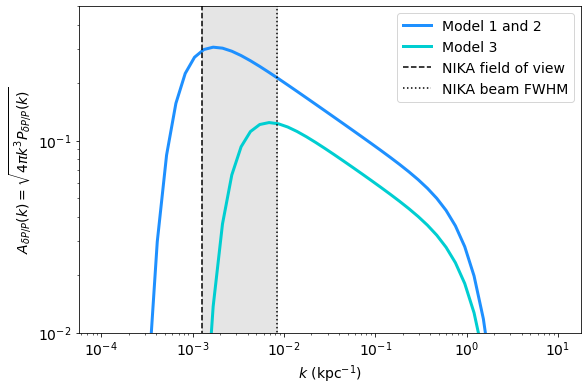

In [31]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(9, 6))
k1,pk1 = cl_model1.get_pressure_fluctuation_spectrum(np.logspace(-1,4)*u.Mpc**-1)
k2,pk2 = cl_model3.get_pressure_fluctuation_spectrum(np.logspace(-1,4)*u.Mpc**-1)
plt.loglog(k1.to_value('kpc-1'), np.sqrt(4*np.pi*k1**3*pk1).to_value(''), lw=3, label='Model 1 and 2', color='dodgerblue')
plt.loglog(k2.to_value('kpc-1'), np.sqrt(4*np.pi*k2**3*pk2).to_value(''), lw=3, label='Model 3', color='darkturquoise')

plt.vlines(1/(FoV_diameter*cl_model.R500/cl_model.theta500).to_value('kpc'),0, 1,
           ls='--', color='k', label='NIKA field of view')
plt.vlines(1/(beam_FWHM*cl_model.R500/cl_model.theta500).to_value('kpc'),0, 1, 
           ls=':', color='k', label='NIKA beam FWHM')
plt.fill_between(np.array([1/(FoV_diameter*cl_model.R500/cl_model.theta500).to_value('kpc'), 1/(beam_FWHM*cl_model.R500/cl_model.theta500).to_value('kpc')]), 
                 np.array([1e-2, 1e-2]), np.array([1, 1]), color='grey', alpha=0.2)

plt.ylim(0.01,0.5)
plt.ylabel(r'$A_{\delta P/P}(k) = \sqrt{4 \pi k^3 P_{\delta P/P}(k)}$')
plt.xlabel(r'$k$ (kpc$^{-1}$)')
plt.legend()
plt.savefig(outdir+'/Test_model_comparison_input.pdf')